[ EMOTION CLASSIFICATION - ANGRY ]<hr>

- 분류/지도학습
- DNN MODEL
- ANGRY 판별 여부

In [16]:
## 모듈 로딩 
import torch                                            ## 텐서 및 기본 함수들 모듈
import torch.nn as nn                                   ## 인공신경망 관련 모듈
import torch.nn.functional as F                         ## 인공신경망 관련 함수들 모듈
import torch.optim as optim                             ## 인공신경망 관련 최적화 모듈
from torch.optim.lr_scheduler import ReduceLROnPlateau  ## 학습률 조정 

from torchinfo import summary                           ## 모델 정보 및 구조 확인 모듈
from torchmetrics.classification import *               ## 모델 성능 지표 관련 모듈

from torchvision.datasets import ImageFolder            ## 이미지용 데이터셋 생성 모듈
from torch.utils.data import DataLoader                 ## 데이터 셋 관련 모듈
from torch.utils.data import Subset, random_split       
from torchvision.transforms import transforms           ## 이미지 전처리 및 증강 모듈
from torch.autograd import Variable
from PIL import Image

import matplotlib.pyplot as plt                         ## 이미지 시각화 

from utils import get_custom_subset, count_images_in_subset, relabel_dataset, FocalLoss, predict_image

In [17]:
from DNNmodel import EmotionDNN
from model_funcion import *

[ 이미지 증강 ]<hr>
- angry 46000장
- angry 제외한 46000장

In [18]:
from torchvision import transforms as tf
from torchvision.datasets import ImageFolder

import os
import random
from PIL import Image, ImageOps
import torch

In [19]:
# 각종 LIB 충돌 방지를 위한 환경 설정

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [20]:
IMG_DIR = './data/archive/MMAFEDB/train/angry/'

In [22]:
TARGET_COUNT = 30000  # 목표 이미지 개수

In [23]:
# 현재 이미지 목록 가져오기
images = os.listdir(IMG_DIR)
current_count = len(images)

# 데이터 증강 정의
augmentation = tf.Compose([
    tf.RandomRotation(degrees=(-30, 30), expand=True),   # 랜덤 회전
    tf.RandomHorizontalFlip(p=0.5),                      # 좌우 반전 (50% 확률)
    tf.RandomVerticalFlip(p=0.5),                        # 상하 반전 (50% 확률)
    tf.ToTensor()
])

def save_image(tensor_img, save_path):
    img = tf.ToPILImage()(tensor_img)
    img.save(save_path)

# 기존 이미지 저장하기
for img_name in images:
    src_path = os.path.join(IMG_DIR, img_name)
    dst_path = os.path.join(IMG_DIR, img_name)
    img = Image.open(src_path).convert('L')  # Grayscale로 변환
    img.save(dst_path)

# 데이터 증강으로 목표 개수까지 증가시키기
while current_count < TARGET_COUNT:
    img_name = random.choice(images)
    img_path = os.path.join(IMG_DIR, img_name)
    
    with Image.open(img_path) as img:
        img = img.convert('L')  # Grayscale로 변환
        tensor_img = tf.ToTensor()(img)
        
        # 증강 처리
        augmented_img = augmentation(img)
        
        # 이미지 저장
        new_img_name = f'augmented_{current_count}.png'
        save_path = os.path.join(IMG_DIR, new_img_name)
        save_image(augmented_img, save_path)
        
        current_count += 1

    if current_count % 1000 == 0:
        print(f'현재 이미지 개수: {current_count} / {TARGET_COUNT}')

print(f'\n 총 {current_count}개의 이미지가 {IMG_DIR}에 저장되었습니다.')

현재 이미지 개수: 13000 / 30000
현재 이미지 개수: 14000 / 30000
현재 이미지 개수: 15000 / 30000
현재 이미지 개수: 16000 / 30000
현재 이미지 개수: 17000 / 30000
현재 이미지 개수: 18000 / 30000
현재 이미지 개수: 19000 / 30000
현재 이미지 개수: 20000 / 30000
현재 이미지 개수: 21000 / 30000
현재 이미지 개수: 22000 / 30000
현재 이미지 개수: 23000 / 30000
현재 이미지 개수: 24000 / 30000
현재 이미지 개수: 25000 / 30000
현재 이미지 개수: 26000 / 30000
현재 이미지 개수: 27000 / 30000
현재 이미지 개수: 28000 / 30000
현재 이미지 개수: 29000 / 30000
현재 이미지 개수: 30000 / 30000

 총 30000개의 이미지가 ./data/archive/MMAFEDB/train/angry/에 저장되었습니다.


[1] 데이터 로딩 및 데이터셋 준비 <hr>

In [24]:
## 데이터 준비
TRAIN_ROOT ='./data/archive/MMAFEDB/train/'
VALID_ROOT ='./data/archive/MMAFEDB/valid/'
TEST_ROOT ='./data/archive/MMAFEDB/test/'

- [1-2] 이미지 데이터 로딩 

In [25]:
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), # Grayscale 변환
    transforms.Resize((48, 48)),
    transforms.ToTensor(),                        # (1, 48, 48)
    transforms.Normalize((0.5,), (0.5,))          # 채널 1개 -> 평균, 표준편차도 1개씩
])

valid_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [26]:
## - 이미지 데이터 로딩 
TRAINDS = ImageFolder(root=TRAIN_ROOT,
                        transform=train_transform)
VALIDDS = ImageFolder(root=VALID_ROOT, 
                    transform=valid_transform)
TESTDS = ImageFolder(root=TEST_ROOT, 
                    transform=test_transform)

In [27]:
## - 클래스 변환 데이터 
IDX_TO_CLASS = {v:k for k, v in TRAINDS.class_to_idx.items()}
print(f'IDX_TO_CLASS => {IDX_TO_CLASS}')

IDX_TO_CLASS => {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [28]:
## - 데이터 확인
print(f'imgDataset 개수 : {len(TRAINDS.targets)}개')
print(f'imgDataset 분류 : {TRAINDS.class_to_idx}')
print(f'- angry      개수 : {TRAINDS.targets.count(0)}개, {(TRAINDS.targets.count(0)/len(TRAINDS.targets))*100}')
print(f'- disgust      개수 : {TRAINDS.targets.count(1)}개, {(TRAINDS.targets.count(1)/len(TRAINDS.targets))*100}')
print(f'- fear      개수 : {TRAINDS.targets.count(2)}개, {(TRAINDS.targets.count(2)/len(TRAINDS.targets))*100}')
print(f'- happy      개수 : {TRAINDS.targets.count(3)}개, {(TRAINDS.targets.count(3)/len(TRAINDS.targets))*100}')
print(f'- neutral      개수 : {TRAINDS.targets.count(4)}개, {(TRAINDS.targets.count(4)/len(TRAINDS.targets))*100}')
print(f'- sad      개수 : {TRAINDS.targets.count(5)}개, {(TRAINDS.targets.count(5)/len(TRAINDS.targets))*100}')
print(f'- surprise      개수 : {TRAINDS.targets.count(6)}개, {(TRAINDS.targets.count(6)/len(TRAINDS.targets))*100}')

imgDataset 개수 : 121908개
imgDataset 분류 : {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
- angry      개수 : 30000개, 24.60872133083965
- disgust      개수 : 4433개, 3.636348721987072
- fear      개수 : 9163개, 7.516323785149456
- happy      개수 : 28592개, 23.453752009712243
- neutral      개수 : 29384개, 24.10342225284641
- sad      개수 : 12223개, 10.0264133608951
- surprise      개수 : 8113개, 6.6550185385700695


In [29]:
# 모든 데이터셋에 대해 라벨 변경하기
relabel_dataset(TRAINDS)
relabel_dataset(VALIDDS)
relabel_dataset(TESTDS)

In [30]:
# 라벨이 제대로 변경되었는지 확인하기
train_labels = [label for _, label in TRAINDS.samples]
test_labels = [label for _, label in TESTDS.samples]
valid_labels = [label for _, label in VALIDDS.samples]

In [31]:
print(f"Train Dataset - 0 (Others): {train_labels.count(0)}, 1 (Angry): {train_labels.count(1)}")
print(f"Test Dataset - 0 (Others): {test_labels.count(0)}, 1 (Angry): {test_labels.count(1)}")
print(f"Valid Dataset - 0 (Others): {valid_labels.count(0)}, 1 (Angry): {valid_labels.count(1)}")

Train Dataset - 0 (Others): 91908, 1 (Angry): 30000
Test Dataset - 0 (Others): 16315, 1 (Angry): 1041
Valid Dataset - 0 (Others): 16339, 1 (Angry): 1017


[ 데이터 불균형 -> 균형으로 맞추기 ]<hr>

In [35]:
classes_to_include_all_images = ['angry', 'disgust']

In [36]:
from utils import get_custom_subset, count_images_in_subset, relabel_dataset

train_subset = get_custom_subset(TRAINDS, 5000, classes_to_include_all_images)

In [38]:
# 'VALIDDS.class_to_idx'에서 클래스별 인덱스를 가져옵니다.
idx_to_classes = {v: k for k, v in VALIDDS.class_to_idx.items()}

# 각 클래스의 샘플 인덱스를 선택하여 리스트에 저장
selected_indices = []
for class_idx in range(len(idx_to_classes)):
    # 'VALIDDS.targets'에서 해당 클래스 인덱스를 가진 샘플들의 인덱스를 선택
    class_indices = [i for i, target in enumerate(VALIDDS.targets) if target == class_idx]
    selected_indices.extend(class_indices)  # 각 클래스의 인덱스를 모두 추가

# 전체 데이터셋의 서브셋을 생성
valid_subset = Subset(VALIDDS, selected_indices)

In [39]:
from collections import Counter

# train_subset에서 각 감정 클래스별 이미지 수 출력
count_images_in_subset(train_subset, TRAINDS)

angry: 30000 images
disgust: 4433 images
fear: 5000 images
happy: 5000 images
neutral: 5000 images
sad: 5000 images
surprise: 5000 images


데이터 로더 준비<hr>

In [40]:
# 데이터로더 설정
TRAINDL= DataLoader(train_subset, batch_size=1000, shuffle=True, generator=torch.Generator().manual_seed(42))
VALIDDL = DataLoader(valid_subset, batch_size=1000, shuffle=False)


print(f"Training data: {len(train_subset)} images")
print(f"Validation data: {len(valid_subset)} images")


Training data: 59433 images
Validation data: 17356 images


In [42]:
# 전체 PyTorch 난수 생성기 시드 설정, 전역적으로 모든 랜덤 생성기의 시드를 설정 즉, PyTorch의 모든 연산에 영향
torch.manual_seed(42)

torch.Size([1000, 1, 48, 48]) tensor([1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
        1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
        1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1,
        1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
        1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
        0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,
        0,

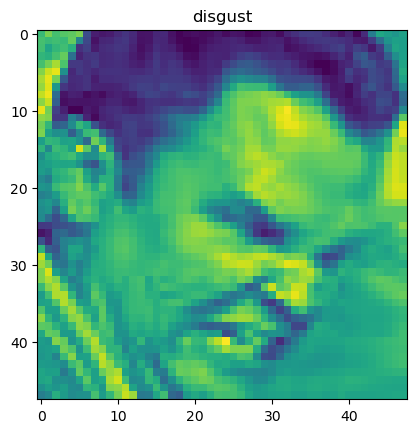

In [43]:
## 체크
img, target = next(iter(TRAINDL))
print(img.shape, target)


print(IDX_TO_CLASS[target[0].item()])  # 첫 번째 이미지의 클래스 이름 

# 첫 번째 이미지를 시각화 (img의 크기가 [batch_size, C, H, W] 형식일 경우)
plt.imshow(img[0].permute(1, 2, 0))  # 이미지는 [C, H, W] 형식이므로, [H, W, C]로 변환하여 표시
plt.title(IDX_TO_CLASS[target[0].item()])  # 첫 번째 이미지의 클래스 이름을 제목으로 설정
plt.show()

[ 모델 정의 및 클래스 설계 ]<hr>

In [44]:
import torch.nn as nn
import torch.nn.functional as F

class EmotionDNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 입력 크기가 48x48인 이미지를 처리하는 레이어로, 48 * 48 = 2304
        self.in_layer   = nn.Flatten()  # 3D (BS, H, W) -> 2D (BS, H*W)
        
        # 첫 번째 Hidden Layer + 배치 정규화 (Batch Normalization)
        self.hd_layer1  = nn.Linear(2304, 512)  # 2304 -> 512
        self.batch_norm1 = nn.BatchNorm1d(512)  # 배치 정규화
        
        # 두 번째 Hidden Layer + 배치 정규화
        self.hd_layer2  = nn.Linear(512, 256)   # 512 -> 256
        self.batch_norm2 = nn.BatchNorm1d(256)  # 배치 정규화
        
        # 세 번째 Hidden Layer
        self.hd_layer3  = nn.Linear(256, 130)
        self.batch_norm3 = nn.BatchNorm1d(130)
        
        self.out_layer  = nn.Linear(130, 1)
        
        self.drop_layer = nn.Dropout(0.5)


    def forward(self, data):
        # 데이터의 크기 출력 (배치 크기, 높이, 너비)
        # print(f'Input data shape: {data.shape}')
        
        # Flatten (3D -> 2D)
        out = self.in_layer(data)
        # print(f'After Flatten: {out.shape}')

        # 첫 번째 Hidden Layer + 배치 정규화 + Dropout
        out = F.relu(self.hd_layer1(out))
        out = self.batch_norm1(out)  # 배치 정규화
        out = self.drop_layer(out)

        # 두 번째 Hidden Layer + 배치 정규화 + Dropout
        out = F.relu(self.hd_layer2(out))
        out = self.batch_norm2(out)  # 배치 정규화
        out = self.drop_layer(out)

        # 세 번째 Hidden Layer
        out = F.relu(self.hd_layer3(out))
        out = self.batch_norm3(out)
        out = self.drop_layer(out)



        # Output Layer
        out = self.out_layer(out)
        
        # print(f'Output shape: {out.shape}')
        return out


In [1]:
## 모델 구조 확인 
from torchinfo import summary 

m1 = EmotionDNN()
summary(m1, input_size=(100, 48, 48))

NameError: name 'EmotionDNN' is not defined

In [ ]:
print(m1)

EmotionDNN(
  (in_layer): Flatten(start_dim=1, end_dim=-1)
  (hd_layer1): Linear(in_features=2304, out_features=512, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hd_layer2): Linear(in_features=512, out_features=256, bias=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hd_layer3): Linear(in_features=256, out_features=130, bias=True)
  (batch_norm3): BatchNorm1d(130, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out_layer): Linear(in_features=130, out_features=1, bias=True)
  (drop_layer): Dropout(p=0.5, inplace=False)
)


[ 모델 학습 ]<hr>

In [ ]:
## 학습 관련 함수
## --------------------------------------------------------------
## - 검증 함수 : 테스트 또는 검증용 데이터셋 사용하는 함수 
##              W,b 업데이트 안함
## --------------------------------------------------------------
def evaluate(model, testDL, loss_fn, score_fn, n_iter):
    # 에포크 단위로 검증 => 검증 모드
    model.eval()

    # W, b가 업데이트 해제
    with torch.no_grad():
        T_LOSS, T_ACC = 0, 0
        for feature, target in testDL:
            # 학습 진행
            pre_y = model(feature)

            # 손실 계산
            target = target.float().unsqueeze(1)  # target을 [batch_size, 1] 형태로 변환
            loss = loss_fn(pre_y, target)
        
            # 정확도 계산: 시그모이드 적용 후 0.5 기준으로 임계값 처리
            pred = torch.sigmoid(pre_y)  # 로짓을 확률로 변환
            pred = (pred >= 0.5).float()  # 확률을 0 또는 1로 변환 (0.5 기준)

            acc = (pred == target).float().mean()  # 정확도 계산

            T_LOSS += loss.item()
            T_ACC  += acc.item()

    return T_LOSS/n_iter, T_ACC/n_iter

In [ ]:
from torchmetrics.classification import BinaryF1Score, BinaryAccuracy

def training(model, trainDL, optimizer, loss_fn, acc_fn, n_iter):
    model.train()

    E_LOSS, E_ACC, E_SCORE = 0, 0, 0
    for feature, target in trainDL:
        feature, target = feature.to(DEVICE), target.to(DEVICE).float().unsqueeze(1)
        
        # 가중치 기울기 초기화
        optimizer.zero_grad()

        # 예측값 계산 (로짓 값)
        pre_y = model(feature)

        # 손실 계산
        loss = loss_fn(pre_y, target)

        # 모델 출력값을 Sigmoid 함수로 확률로 변환
        prob = torch.sigmoid(pre_y)

        # 예측 값(0 또는 1)으로 변환 (명시적으로 threshold=0.5 적용)
        pred = (prob > 0.5).float()

        # 정확도와 F1 Score 계산
        #score = score_fn(pred, target.int())
        
        # 정확도 계산 (acc_fn 사용)
        acc = acc_fn(pred, target.int())  # BinaryAccuracy 인스턴스 사용
        
        # 역전파 진행
        loss.backward()
        
        # 가중치 업데이트
        optimizer.step()

        E_LOSS += loss.item()
        # E_SCORE += score.item()
        E_ACC  += acc.item()

    return E_LOSS / n_iter, E_ACC / n_iter

- DNN MODEL

In [ ]:
from math import ceil
## 학습 설정
EPOCHS      = 50
BATCH_SIZE  = 1000
T_ITERATION = ceil(len(TRAINDS) / BATCH_SIZE)
V_ITERATION = ceil(len(TESTDS) / BATCH_SIZE)

## 최적화 설정
LR          = 0.0005
PAT_CNT     = 10 # 성능 향상이 없을 때 10번의 에폭 후 중단
CLASSES     = len(TRAINDS.classes)

## 학습 및 데이터 로딩 실행 위치/저장 위치
DEVICE      = 'gpu' if torch.cuda.is_available() else 'cpu'

print(f'DEVICE => {DEVICE}')

DEVICE => cpu


In [ ]:
from torchmetrics.classification import *

## 인스턴스 생성
GEN = torch.Generator().manual_seed(42) # 랜덤 시드 고정

MODEL       = EmotionDNN()
OPTIMIZER   = optim.Adam(MODEL.parameters(), lr=LR)
SCHEDULER   = ReduceLROnPlateau(OPTIMIZER, mode='min', patience=PAT_CNT)


LOSS_FN     = FocalLoss()
SCORE_FN    = BinaryAccuracy()

-> 학습 진행  : 모델 또는 가중치 저장 + 성능이 더이상 좋아지지 않으면 조기종료

In [ ]:
## 모델 경로 설정
MODEL_DIR  = './models/'
MODEL_FILE = 'EmotionDNN.pt'

In [ ]:
## 학습 관련 모듈 로딩
# from utils import * 

# 에포크 : DS 처음부터 ~ 끝까지 학습  
HIST ={'Train':[[],[]], 'Valid':[[],[]]} 

# 모델 저장을 위한 기준값 저장 변수 
BEST_ACC = 0

# 조기종료 위한 기준값 저장 변수
EARLY_STOP = 3

# 에포크 단위 학습/검증 진행 
for epoch in range(EPOCHS):
    trainLoss, trainAcc = training(MODEL, TRAINDL, OPTIMIZER, LOSS_FN, SCORE_FN, T_ITERATION)
    validLoss, validAcc = evaluate(MODEL, VALIDDL, LOSS_FN, SCORE_FN, V_ITERATION)

    ## 모델 저장
    # if BEST_ACC < validAcc:   # 0 < 0.1212  ==>  0.1212 < 현재 valacc
    #     #torch.save(MODEL, MODEL_DIR+MODEL_FILE)
    #     torch.save(MODEL, f'{MODEL_DIR}fashion_epoch{epoch}_{validAcc:.3f}.pt')
    #     BEST_ACC = validAcc

    ## 모델 층별 가중치+바이어스 저장
    if BEST_ACC < validAcc:   # 0 < 0.1212  ==>  0.1212 < 현재 valacc
        #torch.save(MODEL.state_dict(), MODEL_DIR+MODEL_FILE)
        torch.save(MODEL.state_dict(), f'{MODEL_DIR}emotion_2st_weights_epoch{epoch}_{validAcc:.3f}.pt')
        BEST_ACC = validAcc

    # 학습 상태 저장
    HIST['Train'][0].append(trainLoss) 
    HIST['Train'][1].append(trainAcc) 
    
    HIST['Valid'][0].append(validLoss) 
    HIST['Valid'][1].append(validAcc) 

    # 학습 상태 시각화
    print(f'\nEPOCH[{epoch}/{EPOCHS}]----------------')
    print(f'- TRAIN_LOSS {trainLoss:.5f}  ACC {trainAcc:.5f}')
    print(f'- VALID_LOSS {validLoss:.5f}  ACC {validAcc:.5f}')
    
    # 조기종료 체크
    SCHEDULER.step(validLoss)
    
    if SCHEDULER.num_bad_epochs >= SCHEDULER.patience:
        EARLY_STOP -= 1
        
    if not EARLY_STOP:
        print(f'{epoch}--[EPOCHS : 성능 개선이 없어서 조기 종료합니다.]')


EPOCH[0/50]----------------
- TRAIN_LOSS 0.01927  ACC 0.35526
- VALID_LOSS 0.02326  ACC 0.92964

EPOCH[1/50]----------------
- TRAIN_LOSS 0.01510  ACC 0.37490
- VALID_LOSS 0.02442  ACC 0.93148

EPOCH[2/50]----------------
- TRAIN_LOSS 0.01403  ACC 0.38242
- VALID_LOSS 0.02509  ACC 0.92745

EPOCH[3/50]----------------
- TRAIN_LOSS 0.01354  ACC 0.38571
- VALID_LOSS 0.02391  ACC 0.93159

EPOCH[4/50]----------------
- TRAIN_LOSS 0.01325  ACC 0.38812
- VALID_LOSS 0.02400  ACC 0.92973

EPOCH[5/50]----------------
- TRAIN_LOSS 0.01308  ACC 0.38945
- VALID_LOSS 0.02488  ACC 0.91930

EPOCH[6/50]----------------
- TRAIN_LOSS 0.01284  ACC 0.39196
- VALID_LOSS 0.02432  ACC 0.90938

EPOCH[7/50]----------------
- TRAIN_LOSS 0.01278  ACC 0.39215
- VALID_LOSS 0.02450  ACC 0.90698

EPOCH[8/50]----------------
- TRAIN_LOSS 0.01259  ACC 0.39470
- VALID_LOSS 0.02382  ACC 0.90632

EPOCH[9/50]----------------
- TRAIN_LOSS 0.01237  ACC 0.39697
- VALID_LOSS 0.02415  ACC 0.90248

EPOCH[10/50]----------------


[ 모델 활용 ]<hr>

In [ ]:
MODEL_DIR = './models/'

In [ ]:
## 저장된 층별 가중치와바이어스 로딩 
WEIGHTS_FILE = MODEL_DIR+'emotion_weights_epoch11_0.943.pt'

model = EmotionDNN()
states=torch.load(WEIGHTS_FILE, weights_only=True)
model.load_state_dict(states)

MODEL_FILE = model.load_state_dict(states)

In [ ]:
MODEL_DIR = './models/'

# 모델 정의 및 가중치 로드
WEIGHTS_FILE = MODEL_DIR+'emotion_weights_epoch11_0.943.pt'


model = EmotionDNN()

states=torch.load(WEIGHTS_FILE, weights_only=True)
model.load_state_dict(states)

model.eval()

# # 모델 객체 전체 저장
# torch.save(model, 'Emotion_DNNMODEL.pt') 

EmotionDNN(
  (in_layer): Flatten(start_dim=1, end_dim=-1)
  (hd_layer1): Linear(in_features=2304, out_features=512, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hd_layer2): Linear(in_features=512, out_features=256, bias=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hd_layer3): Linear(in_features=256, out_features=130, bias=True)
  (batch_norm3): BatchNorm1d(130, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out_layer): Linear(in_features=130, out_features=1, bias=True)
  (drop_layer): Dropout(p=0.5, inplace=False)
)

[ 예측 ]<hr>

In [ ]:
image_path = r'C:\Users\KDT-37\Desktop\KDT_7\10_DL\project\data\archive\MMAFEDB\valid\happy\98Exp3angry_actor_653.jpg'

In [ ]:
result, confidence = predict_image(model, image_path)
print(f"예측된 감정: {result}, 확률: {confidence:.2f}")

예측된 감정: not angry, 확률: 0.73


In [ ]:
image_path = r'C:\Users\KDT-37\Desktop\KDT_7\10_DL\project\1.png'

In [ ]:
result, confidence = predict_image(model, image_path)
print(f"예측된 감정: {result}, 확률: {confidence:.2f}")

예측된 감정: not angry, 확률: 0.63
